# Simulation of denoising details on FC
Rhodri Cusack and Graham King 20/03/2024 cusackrh@tcd.ie

## Zeroing vs. Scrubbing
To compare effect of zeroing out timepoints vs. scrubbing them out, on Pearson

In [86]:
ntp = 288 # number of time points
spike_prob = 0.3 # probability of a scan being a spike
nreg = 10 # number of regions
nmod = 2 # number of modules (sets of regions that covary)
modsig = 0.4    # proportion of signal vs. noise
movsig = 2   # size of movement

vmin = -0.5 
vmax = 0.5

import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

In [87]:
# Create raw data
dat = (1-modsig) * np.random.randn(ntp, nreg) + modsig * np.kron(np.random.randn(ntp, nmod), np.ones(nreg//nmod))

# Add spikes
dat_with_spikes = dat.copy()    
dat_with_spikes_zeroed = dat.copy()
dat_with_spikes_scrubbed = []

# Spike or not?
spikes = np.random.rand(ntp)<spike_prob

for i in range(ntp):
    if spikes[i]:
        dat_with_spikes[i,:] = dat[i,:]  + movsig * np.random.randn(nreg)   # add spike noise
        dat_with_spikes_zeroed[i,:] = 0     # zeroed out, for this simulation, we know exactly where values to be scrubbed are
    else:
        dat_with_spikes_scrubbed.append(dat[i,:])   # scrubbed, for this simulation, we know exactly where values to be scrubbed are

dat_with_spikes_scrubbed = np.array(dat_with_spikes_scrubbed)


In [88]:
# Visualize functions
def show_tc(ax, dat,title, xlim = None, ylim = None):
    # Show timecourses
    ax.plot(dat)
    ax.set_title(title)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
def show_fc(ax, dat,title):
    # Show functional connectivity
    fc = np.corrcoef(dat.T)
    im = ax.imshow(fc,vmin = vmin, vmax=vmax)
    ax.set_title(title)
    plt.colorbar(im, ax = ax)
    return fc
    



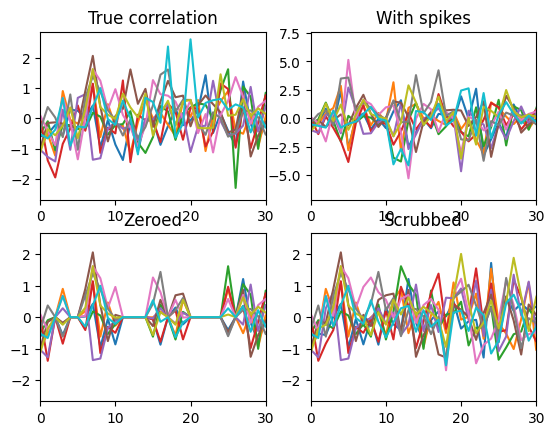

In [89]:
# Show timecourses
fig, ax = plt.subplots(nrows=2, ncols=2)
show_tc(ax[0,0], dat, 'True correlation', xlim = [0,30])
show_tc(ax[0,1], dat_with_spikes, 'With spikes', xlim = [0,30])
show_tc(ax[1,0], dat_with_spikes_zeroed, 'Zeroed', xlim = [0,30])
show_tc(ax[1,1], dat_with_spikes_scrubbed, 'Scrubbed', xlim = [0,30])

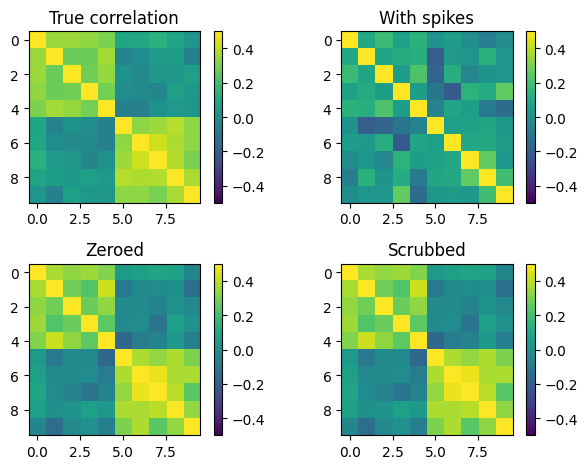

In [90]:
# Show functional connectivity
fig, ax = plt.subplots(nrows=2, ncols=2)

show_fc(ax[0,0], dat, 'True correlation')
show_fc(ax[0,1], dat_with_spikes, 'With spikes')
fc_zeroed = show_fc(ax[1,0], dat_with_spikes_zeroed, 'Zeroed')
fc_scrubbed = show_fc(ax[1,1], dat_with_spikes_scrubbed, 'Scrubbed')

plt.tight_layout()

Text(0.5, 1.0, 'Differences between zeroed and scrubbed')

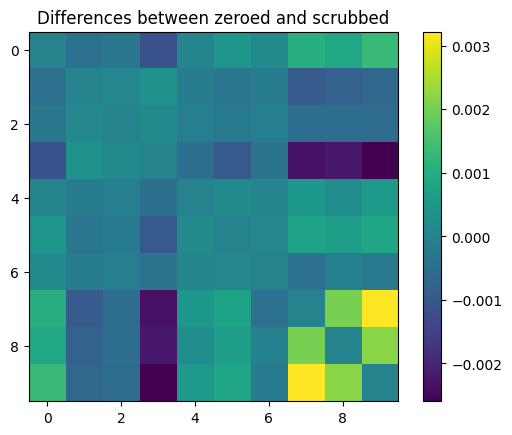

In [91]:
#plt.hist(100*(fc_zeroed.flatten()-fc_scrubbed.flatten())/fc_scrubbed.flatten(), bins = 100, alpha = 0.5, label = 'Zeroed')
plt.imshow(fc_zeroed-fc_scrubbed)
plt.colorbar()
plt.title('Differences between zeroed and scrubbed')


## Effect of order of zeroing and filtering

In [92]:
# Effect of smoothing
from nilearn import signal

# Filter before zeroing
dat_with_spikes_filt = signal.clean(dat_with_spikes, standardize = False, detrend = False, confounds = None, low_pass = 0.1, high_pass = 0.01, t_r = 0.681, ensure_finite = True)

dat_with_spikes_filt_zeroed = dat_with_spikes_filt.copy()
dat_with_spikes_filt_scrubbed = []


# Filter after zeroing
dat_with_spikes_zeroed_filt = signal.clean(dat_with_spikes_filt_zeroed, standardize = False, detrend = False, confounds = None, low_pass = 0.1, high_pass = 0.01, t_r = 0.681, ensure_finite = True)
dat_with_spikes_zeroed_filt_rezeroed = dat_with_spikes_zeroed_filt.copy()

for i in range(ntp):
    if np.random.rand() < spike_prob:
        dat_with_spikes_filt_zeroed[i,:] = 0     # zeroed out, for this simulation, we know exactly where values to be scrubbed are
        dat_with_spikes_zeroed_filt_rezeroed[i,:] = 0



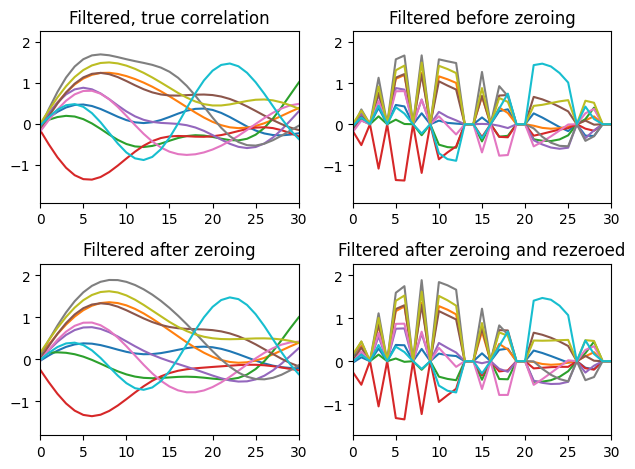

In [93]:
# Show timecourses
fig, ax = plt.subplots(nrows=2, ncols=2)
show_tc(ax[0,0], dat_with_spikes_filt, 'Filtered, true correlation', xlim = [0,30])
show_tc(ax[0,1], dat_with_spikes_filt_zeroed, 'Filtered before zeroing', xlim = [0,30])
show_tc(ax[1,0], dat_with_spikes_zeroed_filt, 'Filtered after zeroing', xlim = [0,30])
show_tc(ax[1,1], dat_with_spikes_zeroed_filt_rezeroed, 'Filtered after zeroing and rezeroed', xlim = [0,30])
plt.tight_layout()


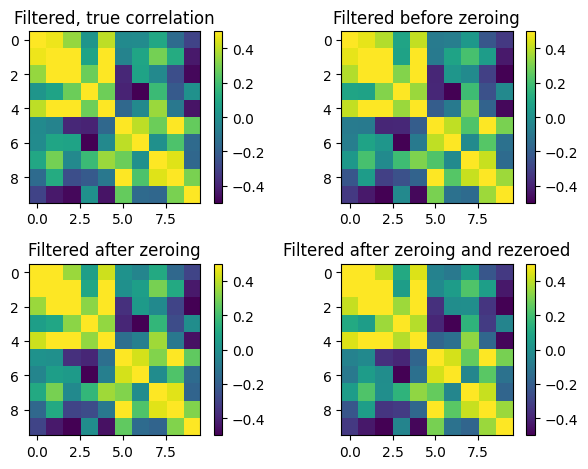

In [97]:
fig, ax = plt.subplots(nrows=2, ncols=2)

fc_with_spikes_filt = show_fc(ax[0,0], dat_with_spikes_filt, 'Filtered, true correlation')
fc_with_spikes_filt_zeroed = show_fc(ax[0,1], dat_with_spikes_filt_zeroed, 'Filtered before zeroing')
fc_with_spikes_zeroed_filt = show_fc(ax[1,0], dat_with_spikes_zeroed_filt, 'Filtered after zeroing')
fc_with_spikes_zeroed_filt_rezeroed = show_fc(ax[1,1], dat_with_spikes_zeroed_filt_rezeroed, 'Filtered after zeroing and rezeroed')

plt.tight_layout()


In [98]:
print('Errors')
print(f' filt_zeroed {np.std(fc_with_spikes_filt - fc_with_spikes_filt_zeroed)}')
print(f' zeroed_filt {np.std(fc_with_spikes_filt - fc_with_spikes_zeroed_filt)}')
print(f' zeroed_filt_rezeroed {np.std(fc_with_spikes_filt - fc_with_spikes_zeroed_filt_rezeroed)}')



Errors
 filt_zeroed 0.03855709826653814
 zeroed_filt 0.02465423361779426
 zeroed_filt_rezeroed 0.05022525363056374
